# Environment Setup and Imports

In [1]:
import os
import sys
import time
from datetime import datetime
import platform
import warnings
warnings.filterwarnings('ignore')

# Platform detection and configuration
PLATFORM = platform.system()
IS_EMR = 'EMR' in os.environ.get('AWS_EXECUTION_ENV', '')

print(f"Running on: {PLATFORM}")
print(f"Is EMR: {IS_EMR}")
print(f"Python version: {sys.version}")

# Set environment variables based on platform
if PLATFORM == "Windows":
    # Windows configuration
    os.environ["PYSPARK_PYTHON"] = sys.executable
    os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
    if "JAVA_HOME" not in os.environ:
        # Common Java paths on Windows
        java_paths = ["C:\\Program Files\\Java\\jdk-11", "C:\\Zulu\\zulu-11"]
        for path in java_paths:
            if os.path.exists(path):
                os.environ["JAVA_HOME"] = path
                break
else:
    # Linux configuration (Ubuntu/EMR)
    os.environ["PYSPARK_PYTHON"] = sys.executable
    os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
    if "JAVA_HOME" not in os.environ:
        os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# Import required libraries
import numpy as np
import pandas as pd
from PIL import Image
import io
from typing import List, Tuple, Dict
import json

# PySpark imports
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, udf, element_at, split, count, when, lit, coalesce
from pyspark.sql.types import ArrayType, FloatType, StringType, IntegerType, BooleanType
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT


Running on: Windows
Is EMR: False
Python version: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]


# Configuration Parameters

In [2]:
# Configuration parameters
CONFIG = {
    "batch_size": 32,
    "image_size": (128, 128),  # Optimized for performance
    "num_features": 512,  # Reduced for better performance
    "test_split": 0.2,
    "seed": 42,
    # Random Forest parameters
    "num_trees": 150,  # Reduced for faster training
    "max_depth": 20,
    "min_instances_per_node": 2,
    "feature_subset_strategy": "sqrt"
}

# Path configuration
if IS_EMR:
    # EMR S3 paths
    DATA_PATH = "s3://your-bucket/fruit-images"  # Update with your S3 bucket
    RESULTS_PATH = "s3://your-bucket/results"
else:
    # Local paths
    DATA_PATH = "data/Test1"  # Update with your local path
    RESULTS_PATH = "data/Results"

print(f"Data path: {DATA_PATH}")
print(f"Results path: {RESULTS_PATH}")


Data path: data/Test1
Results path: data/Results


# Initialize Spark Session

In [3]:
# Start timing
start_time = time.time()
initialization_start = time.time()

# Create Spark session with optimized configuration
def create_spark_session():
    builder = SparkSession.builder \
        .appName("FruitClassification_RandomForest_CrossPlatform") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.maxRecordsPerBatch", str(CONFIG["batch_size"]))
    
    if not IS_EMR:
        # Local configuration
        builder = builder.master("local[*]") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "4g") \
            .config("spark.driver.maxResultSize", "2g") \
            .config("spark.sql.shuffle.partitions", "100")
    else:
        # EMR configuration
        builder = builder \
            .config("spark.sql.shuffle.partitions", "200") \
            .config("spark.default.parallelism", "200")
    
    return builder.getOrCreate()

spark = create_spark_session()
sc = spark.sparkContext

# Print Spark configuration
print(f"Spark version: {spark.version}")
print(f"Number of executors: {sc._jsc.sc().getExecutorMemoryStatus().size()}")
print(f"Default parallelism: {sc.defaultParallelism}")

initialization_time = time.time() - initialization_start
print(f"\nSpark initialization time: {initialization_time:.2f} seconds")


Spark version: 3.5.5
Number of executors: 1
Default parallelism: 16

Spark initialization time: 2.61 seconds


# Load and Prepare Image Data

In [4]:
# Load images
loading_start = time.time()

print(f"Loading images from: {DATA_PATH}")

# Read images with labels from folder structure
images_df = spark.read.format("binaryFile") \
    .option("pathGlobFilter", "*.jpg") \
    .option("recursiveFileLookup", "true") \
    .load(DATA_PATH)

# Extract labels from folder names
images_df = images_df.withColumn('label', element_at(split(col('path'), '/'), -2))

# Add image validation
def validate_image(content):
    try:
        img = Image.open(io.BytesIO(content))
        # Check if image can be processed
        if img.size[0] > 0 and img.size[1] > 0:
            return True
        return False
    except:
        return False

validate_image_udf = udf(validate_image, BooleanType())
images_df = images_df.withColumn('is_valid', validate_image_udf(col('content')))

# Filter out corrupted images
images_df = images_df.filter(col('is_valid') == True).drop('is_valid')

# Cache the dataframe
images_df.cache()

# Count images per class
image_count = images_df.count()
class_distribution = images_df.groupBy('label').count().orderBy('label').collect()

print(f"\nTotal valid images loaded: {image_count}")
print("\nClass distribution:")
for row in class_distribution:
    print(f"  {row['label']}: {row['count']} images")

loading_time = time.time() - loading_start
print(f"\nData loading time: {loading_time:.2f} seconds")


Loading images from: data/Test1

Total valid images loaded: 655

Class distribution:
  Apple Braeburn: 5 images
  Apple Crimson Snow: 5 images
  Apple Golden 1: 5 images
  Apple Golden 2: 5 images
  Apple Golden 3: 5 images
  Apple Granny Smith: 5 images
  Apple Pink Lady: 5 images
  Apple Red 1: 5 images
  Apple Red 2: 5 images
  Apple Red 3: 5 images
  Apple Red Delicious: 5 images
  Apple Red Yellow 1: 5 images
  Apple Red Yellow 2: 5 images
  Apricot: 5 images
  Avocado: 5 images
  Avocado ripe: 5 images
  Banana: 5 images
  Banana Lady Finger: 5 images
  Banana Red: 5 images
  Beetroot: 5 images
  Blueberry: 5 images
  Cactus fruit: 5 images
  Cantaloupe 1: 5 images
  Cantaloupe 2: 5 images
  Carambula: 5 images
  Cauliflower: 5 images
  Cherry 1: 5 images
  Cherry 2: 5 images
  Cherry Rainier: 5 images
  Cherry Wax Black: 5 images
  Cherry Wax Red: 5 images
  Cherry Wax Yellow: 5 images
  Chestnut: 5 images
  Clementine: 5 images
  Cocos: 5 images
  Corn: 5 images
  Corn Husk: 5 

# Simple Feature Extraction Functions

In [5]:
# Simplified feature extraction for better compatibility
def extract_simple_features(image_bytes: bytes) -> List[float]:
    """Extract simple features from image"""
    try:
        img = Image.open(io.BytesIO(image_bytes))
        img = img.resize(CONFIG["image_size"])
        
        # Convert to numpy array
        img_array = np.array(img)
        
        features = []
        
        # 1. Color histogram features (RGB)
        for channel in range(3):
            hist, _ = np.histogram(img_array[:,:,channel], bins=16, range=(0, 256))
            features.extend(hist.tolist())
        
        # 2. Statistical features per channel
        for channel in range(3):
            channel_data = img_array[:,:,channel].flatten()
            features.extend([
                float(np.mean(channel_data)),
                float(np.std(channel_data)),
                float(np.min(channel_data)),
                float(np.max(channel_data))
            ])
        
        # 3. Simple texture features
        gray = np.dot(img_array[...,:3], [0.2989, 0.5870, 0.1140])
        
        # Gradient features
        dx = np.diff(gray, axis=1)
        dy = np.diff(gray, axis=0)
        
        features.extend([
            float(np.mean(np.abs(dx))),
            float(np.std(dx)),
            float(np.mean(np.abs(dy))),
            float(np.std(dy))
        ])
        
        # Ensure we have exactly num_features
        if len(features) < CONFIG["num_features"]:
            features.extend([0.0] * (CONFIG["num_features"] - len(features)))
        else:
            features = features[:CONFIG["num_features"]]
        
        return features
        
    except Exception as e:
        # Return zeros if error
        return [0.0] * CONFIG["num_features"]

# Create UDF for feature extraction
extract_features_udf = udf(extract_simple_features, ArrayType(FloatType()))


# Extract Features

In [6]:
# Extract features and create vectors directly
feature_extraction_start = time.time()

print("Extracting features from images...")

# Repartition for optimal performance
optimal_partitions = min(sc.defaultParallelism * 2, 100)
images_df_repartitioned = images_df.repartition(optimal_partitions)

# Apply feature extraction
features_df = images_df_repartitioned.select(
    col("path"),
    col("label"),
    extract_features_udf(col("content")).alias("features")
)

# Convert array directly to vector
def array_to_vector(features):
    if features is None:
        return Vectors.dense([0.0] * CONFIG["num_features"])
    return Vectors.dense(features)

array_to_vector_udf = udf(array_to_vector, VectorUDT())

# Create features vector directly
features_vector_df = features_df.select(
    col("path"),
    col("label"),
    array_to_vector_udf(col("features")).alias("features_vector")
)

# Cache processed features
features_vector_df.cache()
processed_count = features_vector_df.count()

print(f"Successfully processed {processed_count} images")

feature_extraction_time = time.time() - feature_extraction_start
print(f"\nFeature extraction time: {feature_extraction_time:.2f} seconds")


Extracting features from images...
Successfully processed 655 images

Feature extraction time: 16.60 seconds


# Prepare Data for Training

In [7]:
# Prepare data for ML
preparation_start = time.time()

# Index labels
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
label_indexer_model = label_indexer.fit(features_vector_df)

# Get label mappings
labels = label_indexer_model.labels
print(f"Classes found: {labels}")
print(f"Number of classes: {len(labels)}")

# Split data
train_df, test_df = features_vector_df.randomSplit([1-CONFIG["test_split"], CONFIG["test_split"]], 
                                                   seed=CONFIG["seed"])

train_count = train_df.count()
test_count = test_df.count()

print(f"\nTraining samples: {train_count}")
print(f"Test samples: {test_count}")

preparation_time = time.time() - preparation_start
print(f"\nData preparation time: {preparation_time:.2f} seconds")


Classes found: ['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'M

# Train Classification Model

In [8]:
# Train model
training_start = time.time()

print("Training Random Forest model...")

# Feature scaling
scaler = StandardScaler(
    inputCol="features_vector", 
    outputCol="scaled_features",
    withStd=True,
    withMean=False
)

# Create Random Forest classifier
rf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="label_index",
    numTrees=CONFIG["num_trees"],
    maxDepth=CONFIG["max_depth"],
    minInstancesPerNode=CONFIG["min_instances_per_node"],
    featureSubsetStrategy=CONFIG["feature_subset_strategy"],
    seed=CONFIG["seed"]
)

# Create pipeline
pipeline = Pipeline(stages=[label_indexer_model, scaler, rf])

# Train model
print(f"Training with {CONFIG['num_trees']} trees and max depth {CONFIG['max_depth']}...")
model = pipeline.fit(train_df)

# Get the Random Forest model from the pipeline
rf_model = model.stages[-1]

training_time = time.time() - training_start
print(f"\nModel training time: {training_time:.2f} seconds")


Training Random Forest model...
Training with 150 trees and max depth 20...

Model training time: 43.82 seconds


# Evaluate Model

In [9]:
# Evaluate model
evaluation_start = time.time()

print("Evaluating model performance...")

# Make predictions on test set
predictions = model.transform(test_df)

# Calculate metrics
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="accuracy"
)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="f1"
)
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="weightedPrecision"
)
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label_index", predictionCol="prediction", metricName="weightedRecall"
)

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

# Get feature importance
feature_importance = rf_model.featureImportances

evaluation_time = time.time() - evaluation_start
print(f"\nModel evaluation time: {evaluation_time:.2f} seconds")

# Print results
print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE RESULTS")
print(f"{'='*60}")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1 Score:  {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


Evaluating model performance...

Model evaluation time: 2.51 seconds

MODEL PERFORMANCE RESULTS
Accuracy:  0.7969 (79.69%)
F1 Score:  0.7929
Precision: 0.8294
Recall:    0.7969


In [10]:
# Import PCA from PySpark ML
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# PCA Analysis
pca_start = time.time()
print("Performing PCA analysis...")

# Create PCA model with 2 components for visualization
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")

# We need to get the scaled features from our pipeline
# First, transform the entire dataset through the pipeline stages except the classifier
scaler_model = model.stages[1]  # Get the scaler from the trained pipeline
scaled_df = features_vector_df.select(
    col("path"),
    col("label"),
    col("features_vector")
)

# Apply label indexing
scaled_df = label_indexer_model.transform(scaled_df)

# Apply scaling
scaled_df = scaler_model.transform(scaled_df)

# Fit PCA model
pca_model = pca.fit(scaled_df)

# Transform data
pca_result = pca_model.transform(scaled_df)

# Extract explained variance - convert DenseVector to list
explained_variance = pca_model.explainedVariance.toArray()  # Convert to numpy array
print(f"Explained variance ratio: {explained_variance}")

# Convert to Pandas for visualization
pca_df = pca_result.select("label", "pca_features").toPandas()

# Extract PCA components
pca_df['pca_1'] = pca_df['pca_features'].apply(lambda x: float(x[0]))
pca_df['pca_2'] = pca_df['pca_features'].apply(lambda x: float(x[1]))

pca_time = time.time() - pca_start
print(f"\nPCA analysis time: {pca_time:.2f} seconds")


Performing PCA analysis...
Explained variance ratio: [0.23668179 0.10264171]

PCA analysis time: 2.16 seconds


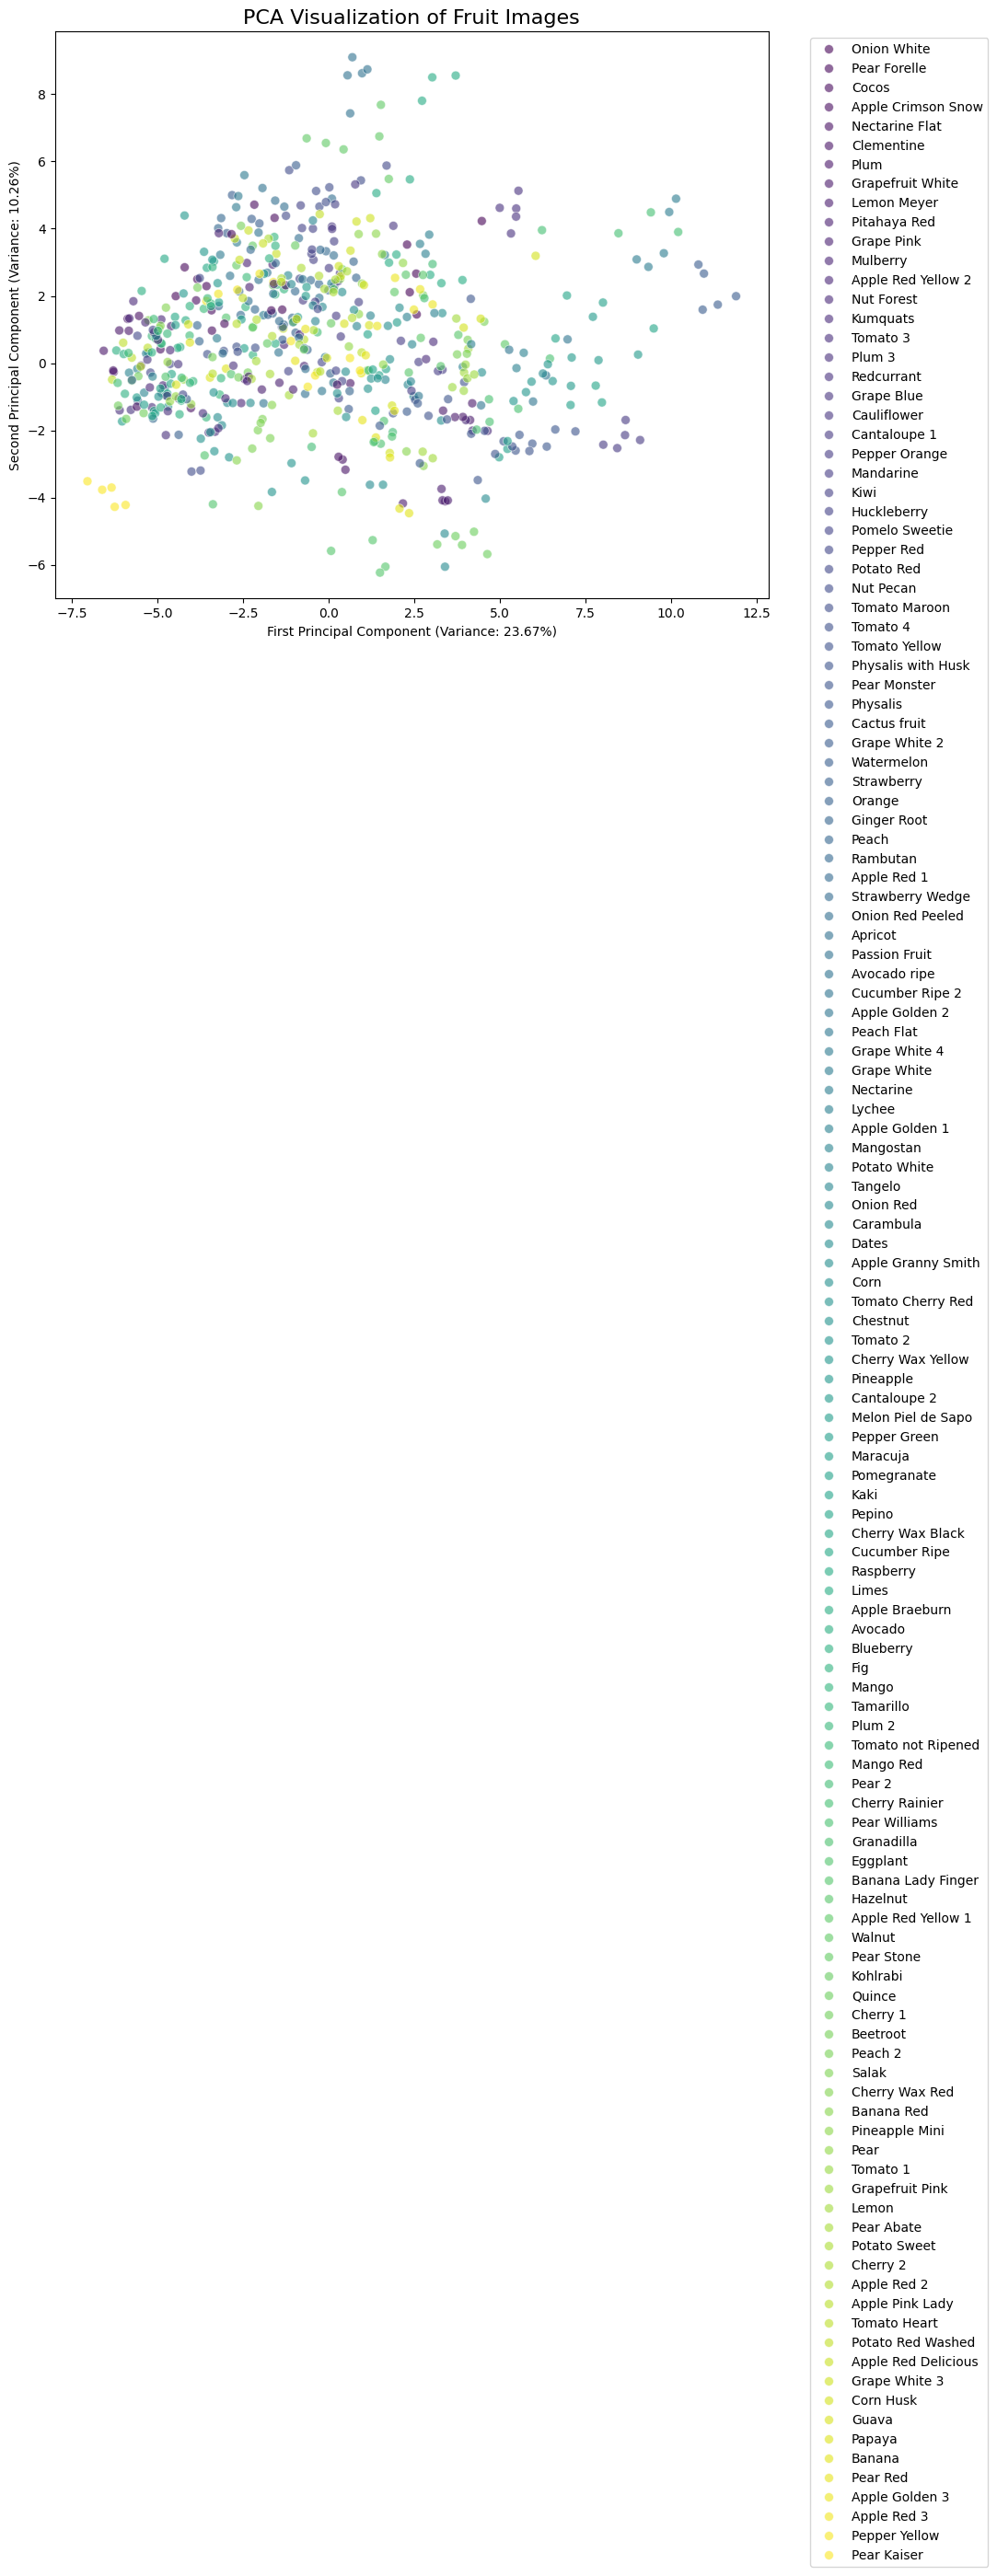


PCA Summary:
Total variance explained by 2 components: 33.93%
Component 1 variance: 23.67%
Component 2 variance: 10.26%


In [12]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='pca_1', y='pca_2', hue='label', 
                palette='viridis', alpha=0.6, s=50)
plt.title('PCA Visualization of Fruit Images', fontsize=16)
plt.xlabel(f'First Principal Component (Variance: {explained_variance[0]:.2%})')
plt.ylabel(f'Second Principal Component (Variance: {explained_variance[1]:.2%})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print PCA summary
print(f"\nPCA Summary:")
print(f"Total variance explained by 2 components: {sum(explained_variance):.2%}")
print(f"Component 1 variance: {explained_variance[0]:.2%}")
print(f"Component 2 variance: {explained_variance[1]:.2%}")


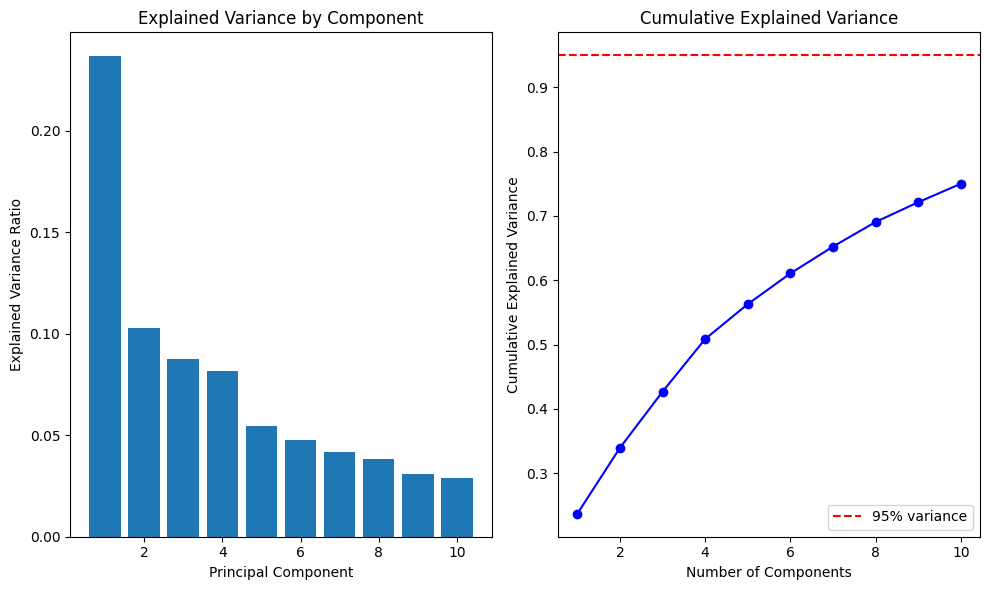


Variance explained by first 10 components:
Component 1: 0.2367 (23.67%)
Component 2: 0.1026 (10.26%)
Component 3: 0.0874 (8.74%)
Component 4: 0.0819 (8.19%)
Component 5: 0.0543 (5.43%)
Component 6: 0.0477 (4.77%)
Component 7: 0.0417 (4.17%)
Component 8: 0.0383 (3.83%)
Component 9: 0.0308 (3.08%)
Component 10: 0.0287 (2.87%)

Cumulative variance with 10 components: 75.01%


In [13]:
# Optional: Analyze with more components to see variance explained
pca_full = PCA(k=10, inputCol="scaled_features", outputCol="pca_features_full")
pca_full_model = pca_full.fit(scaled_df)

# Get explained variance for multiple components - convert to array
explained_variance_full = pca_full_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance_full)

# Plot explained variance
plt.figure(figsize=(10, 6))
components = range(1, len(explained_variance_full) + 1)
plt.subplot(1, 2, 1)
plt.bar(components, explained_variance_full)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')

plt.subplot(1, 2, 2)
plt.plot(components, cumulative_variance, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nVariance explained by first 10 components:")
for i, var in enumerate(explained_variance_full):
    print(f"Component {i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"\nCumulative variance with 10 components: {cumulative_variance[-1]:.2%}")


# Save Results and Summary

In [14]:
# Calculate total time
total_time = time.time() - start_time

# Prepare results
results = {
    "platform": {
        "system": PLATFORM,
        "is_emr": IS_EMR,
        "spark_version": spark.version,
        "python_version": sys.version.split()[0],
        "executors": sc._jsc.sc().getExecutorMemoryStatus().size(),
        "default_parallelism": sc.defaultParallelism
    },
    "data": {
        "total_images": image_count,
        "processed_images": processed_count,
        "train_samples": train_count,
        "test_samples": test_count,
        "num_classes": len(labels),
        "classes": labels
    },
    "model": {
        "type": "RandomForestClassifier",
        "num_trees": CONFIG["num_trees"],
        "max_depth": CONFIG["max_depth"],
        "num_features": CONFIG["num_features"]
    },
    "performance": {
        "accuracy": float(accuracy),
        "f1_score": float(f1_score),
        "precision": float(precision),
        "recall": float(recall)
    },
    "timing": {
        "initialization_time": initialization_time,
        "loading_time": loading_time,
        "feature_extraction_time": feature_extraction_time,
        "preparation_time": preparation_time,
        "training_time": training_time,
        "evaluation_time": evaluation_time,
        "pca_time": pca_time,  # Add this line
        "total_time": total_time
    },
    "pca_analysis": {
        "components_analyzed": 2,
        "explained_variance_component1": float(explained_variance[0]),
        "explained_variance_component2": float(explained_variance[1]),
        "total_variance_explained": float(sum(explained_variance)),
        "pca_time": pca_time
    },
    "timestamp": datetime.now().isoformat()
}

# Print summary
print(f"\n{'='*60}")
print(f"EXECUTION SUMMARY")
print(f"{'='*60}")
print(f"Platform: {results['platform']['system']} {'(EMR)' if IS_EMR else '(Local)'}")
print(f"Spark Version: {results['platform']['spark_version']}")
print(f"Executors: {results['platform']['executors']}")
print(f"Parallelism: {results['platform']['default_parallelism']}")
print(f"\nData Summary:")
print(f"  - Total images: {results['data']['total_images']}")
print(f"  - Successfully processed: {results['data']['processed_images']}")
print(f"  - Number of classes: {results['data']['num_classes']}")
print(f"\nModel Configuration:")
print(f"  - Type: {results['model']['type']}")
print(f"  - Trees: {results['model']['num_trees']}")
print(f"  - Max Depth: {results['model']['max_depth']}")
print(f"\nModel Performance:")
print(f"  - Accuracy:  {results['performance']['accuracy']:.2%}")
print(f"  - F1 Score:  {results['performance']['f1_score']:.4f}")
print(f"  - Precision: {results['performance']['precision']:.4f}")
print(f"  - Recall:    {results['performance']['recall']:.4f}")
print(f"\nPCA Analysis:")
print(f"  - Components: 2")
print(f"  - Variance explained: {results['pca_analysis']['total_variance_explained']:.2%}")

print(f"\nExecution Times:")
print(f"  - Initialization: {results['timing']['initialization_time']:.2f}s")
print(f"  - Data Loading: {results['timing']['loading_time']:.2f}s")
print(f"  - Feature Extraction: {results['timing']['feature_extraction_time']:.2f}s")
print(f"  - Data Preparation: {results['timing']['preparation_time']:.2f}s")
print(f"  - Model Training: {results['timing']['training_time']:.2f}s")
print(f"  - Model Evaluation: {results['timing']['evaluation_time']:.2f}s")
print(f"  - PCA Time: {results['pca_analysis']['pca_time']:.2f}s")
print(f"  - TOTAL TIME: {results['timing']['total_time']:.2f}s")
print(f"{'='*60}")

# Save results
if not IS_EMR:
    # Save locally
    os.makedirs(RESULTS_PATH, exist_ok=True)
    results_file = os.path.join(RESULTS_PATH, f"results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to: {results_file}")



EXECUTION SUMMARY
Platform: Windows (Local)
Spark Version: 3.5.5
Executors: 1
Parallelism: 16

Data Summary:
  - Total images: 655
  - Successfully processed: 655
  - Number of classes: 131

Model Configuration:
  - Type: RandomForestClassifier
  - Trees: 150
  - Max Depth: 20

Model Performance:
  - Accuracy:  79.69%
  - F1 Score:  0.7929
  - Precision: 0.8294
  - Recall:    0.7969

PCA Analysis:
  - Components: 2
  - Variance explained: 33.93%

Execution Times:
  - Initialization: 2.61s
  - Data Loading: 14.50s
  - Feature Extraction: 16.60s
  - Data Preparation: 1.48s
  - Model Training: 43.82s
  - Model Evaluation: 2.51s
  - PCA Time: 2.16s
  - TOTAL TIME: 85.90s

Results saved to: data/Results\results_20250620_163933.json


# Cleanup

In [15]:
# Stop Spark session
spark.stop()
print("Spark session closed.")
print("\nExecution completed successfully!")


Spark session closed.

Execution completed successfully!
